In [8]:
import robosuite as suite
import numpy as np
import h5py
import time
import os
import pygame
import sys


from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


from robosuite.wrappers.visualization_wrapper import VisualizationWrapper
from robosuite.devices.keyboard import Keyboard

In [7]:
import subprocess

# Uninstall robosuite and automatically confirm with -y
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "robosuite", "-y"])


Found existing installation: robosuite 1.5.1
Uninstalling robosuite-1.5.1:
  Successfully uninstalled robosuite-1.5.1


0

In [9]:
def plot_xyz_vs_time_by_skill(h5_file_path, sample_rate=50):
    if not os.path.exists(h5_file_path):
        print(f"Error: {h5_file_path} does not exist.")
        return

    skills = ["reach", "transport", "retreat"]
    axis_labels = ["X", "Y", "Z"]

    with h5py.File(h5_file_path, "r") as f:
        demo_names = [k for k in f.keys() if k.startswith("demo")]

        for skill in skills:
            fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
            fig.suptitle(f"{skill.upper()} Skill - X / Y / Z vs Time Step for All Demos")

            for demo_idx, demo_name in enumerate(demo_names):
                if skill not in f[demo_name]:
                    continue

                states = np.array(f[demo_name][skill]["robot_states"])
                T = len(states)
                time = np.arange(T)  # Use time steps instead of seconds

                for i in range(3):  # X, Y, Z
                    axes[i].plot(
                        time,
                        states[:, i],
                        label=f"{demo_name}",
                        color=DEMO_COLORS[demo_idx % len(DEMO_COLORS)],
                        alpha=0.7
                    )
                    axes[i].set_ylabel(f"{axis_labels[i]} [m]")
                    axes[i].grid(True)

            axes[-1].set_xlabel("Time Step")
            axes[0].legend(title="Demos", ncol=3, fontsize="small", loc="upper right")
            plt.tight_layout()
            plt.show()


Plotting X, Y, Z vs Time for Each Skill (Reach & Transport)...



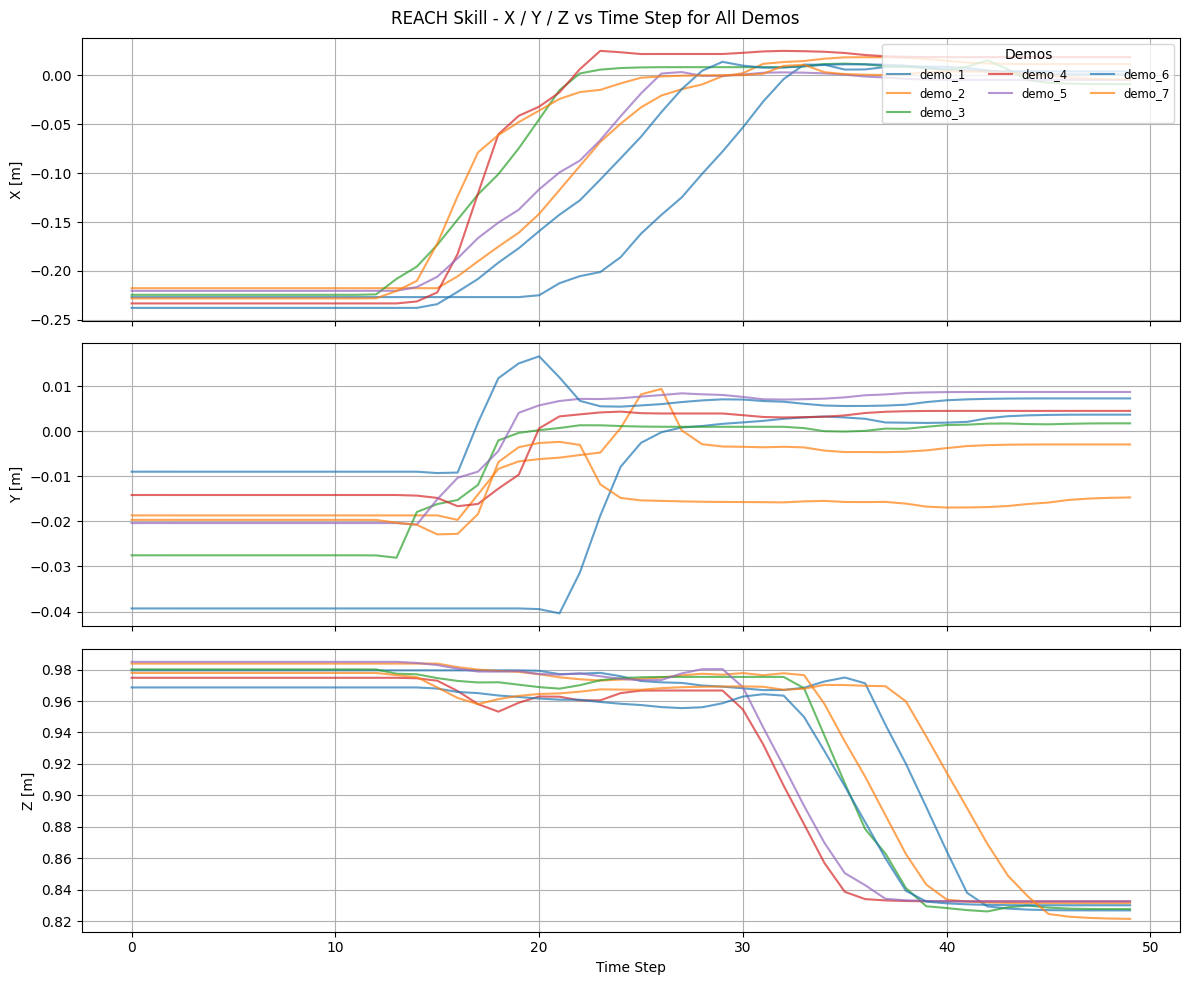

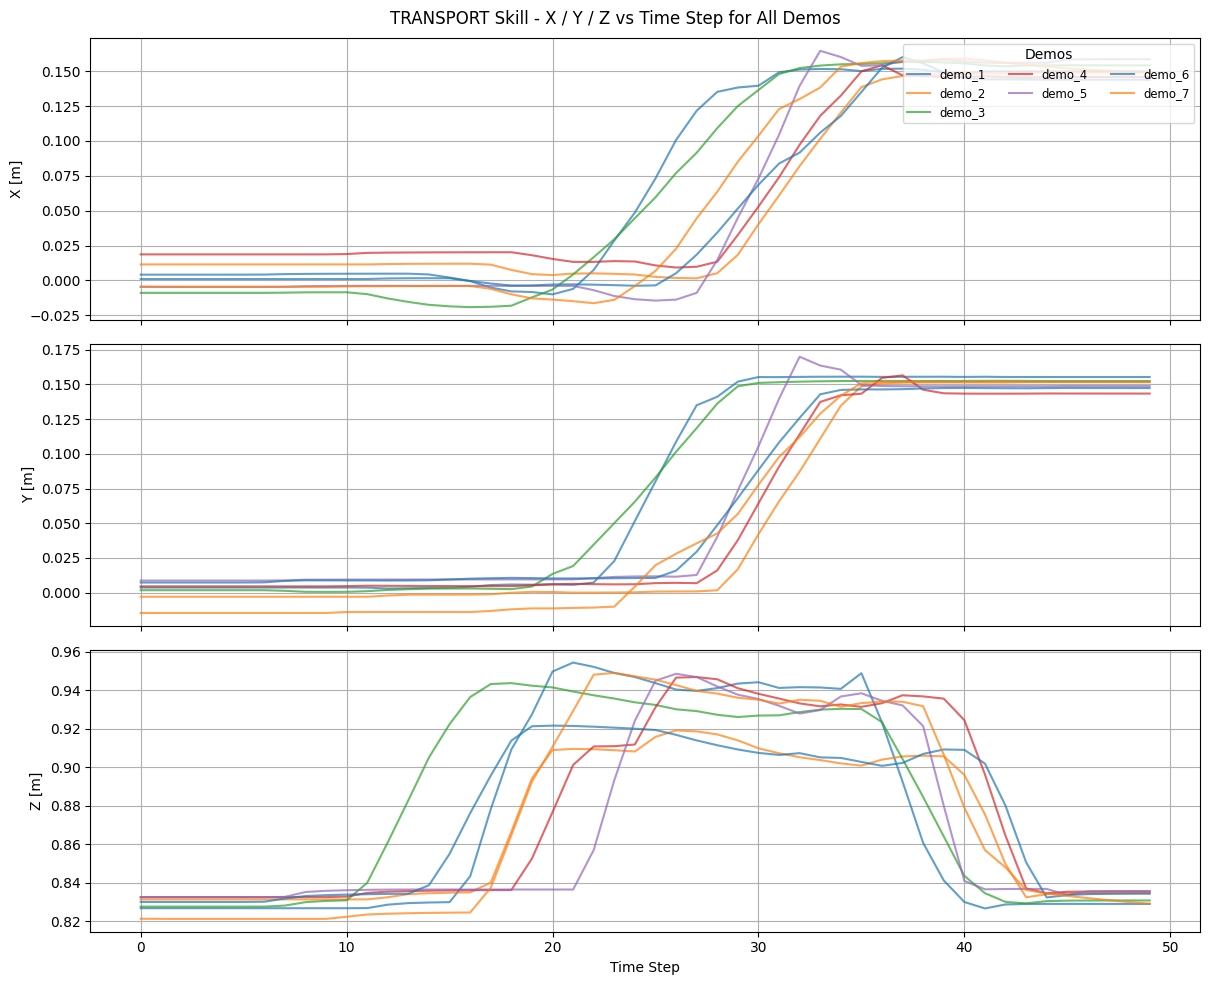

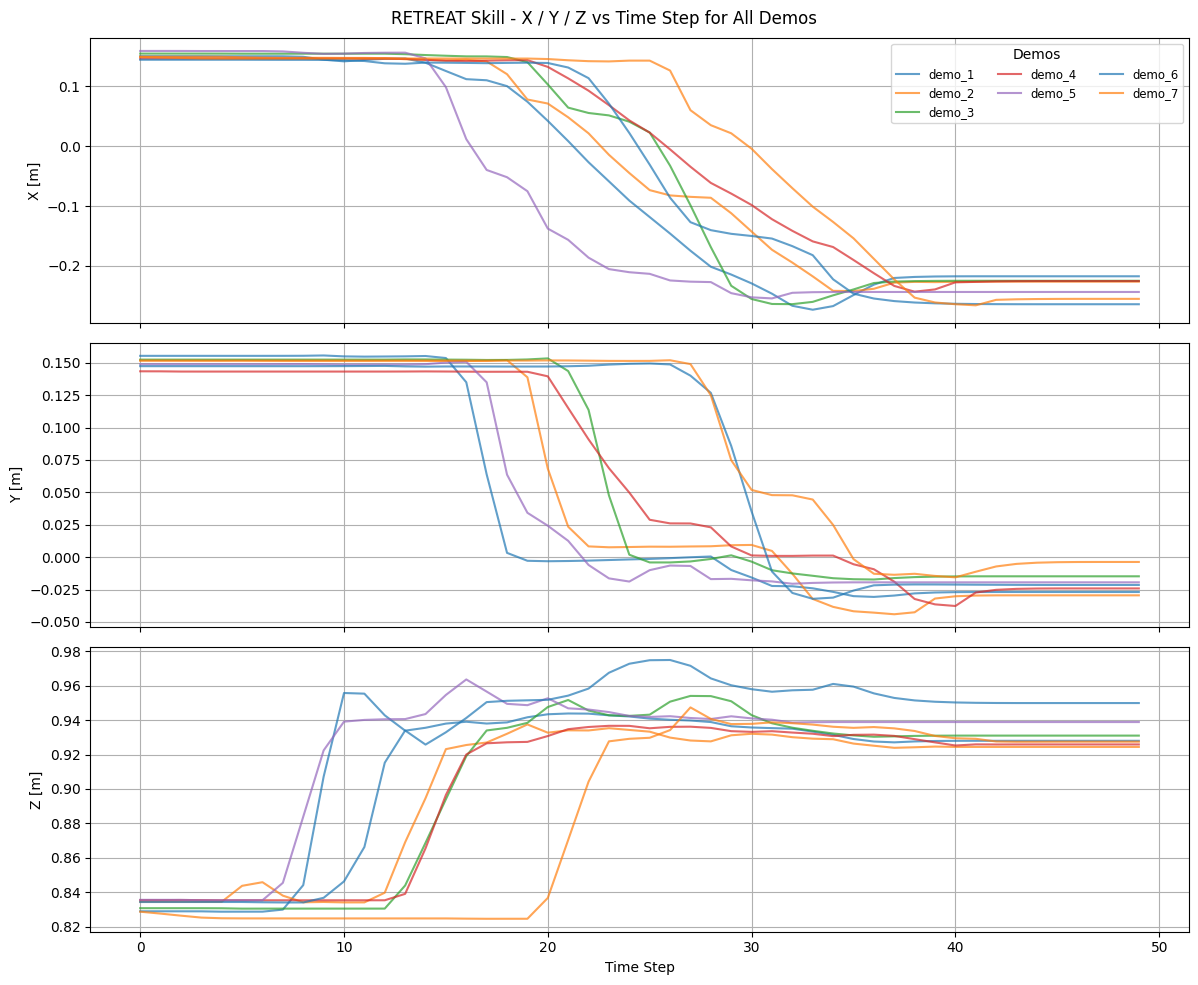

In [10]:
DEMO_COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

segmented_h5 = "DEMO/smoothed_demo/smoothed_skills.h5"

#segmented_h5 = "robosuite/DEMO/recorded_demo/recorded_pick_place_segmented.h5"
print("\nPlotting X, Y, Z vs Time for Each Skill (Reach & Transport)...\n")
plot_xyz_vs_time_by_skill(segmented_h5)


In [11]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kmp.mixture import GaussianMixtureModel
from kmp.model import KMP
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D


In [12]:
def load_demos(path, skill):
    demos, goals = [], []
    with h5py.File(path, "r") as f:
        for name in f:
            if skill not in f[name]:
                continue
            group = f[name][skill]
            if "robot_states" not in group:
                print(f"[WARNING] 'robot_states' not found in demo '{name}' — skipping.")
                continue
            pos = np.array(group["robot_states"]).T
            pos[2] = np.clip(pos[2], 0.81, 1.0)
            demos.append(pos)

            goal = np.array(f[name].get("target_position", np.zeros(3)))
            if goal.ndim > 1:
                goal = goal[0]
            assert goal.shape == (3,), f"Goal shape error: {goal.shape}"
            goals.append(goal)

    print(f"[INFO] Loaded {len(demos)} demos.")
    return demos, goals

def visualize_goals(goals):
    goals_np = np.array(goals)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(goals_np[:, 0], goals_np[:, 1], goals_np[:, 2], c="blue", label="Training Goals")
    ax.set_title("Training Goal Distribution")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def train_kmp(demos, goals):
    T = demos[0].shape[1]
    time = np.linspace(0, 1, T).reshape(1, -1)
    inputs, outputs = [], []

    for demo, goal in zip(demos, goals):
        goal_rep = np.tile(goal.reshape(3, 1), (1, T))
        input_sample = np.vstack((time, goal_rep))
        inputs.append(input_sample)
        outputs.append(demo)

    X = np.hstack(inputs).T   # shape: (N, 4)
    Y = np.hstack(outputs).T  # shape: (N, 3)

    print("[INFO] Fitting GMM to demonstration data...")
    gmm = GaussianMixtureModel(
        n_components=CONFIG["kmp_params"]["n_components"],
        diag_reg_factor=CONFIG["kmp_params"]["diag_reg_factor"]
    )
    gmm.fit(np.hstack([X, Y]))
    mu_gmr, sigma_gmr = gmm.predict(X.T)

    mu_gmr = mu_gmr[:3, :]
    sigma_gmr = sigma_gmr[:3, :3, :]

    print("[INFO] Plotting GMR vs Demonstration data...")
    for d_idx in range(len(demos)):
        plt.figure(figsize=(10, 3))
        for i, coord in enumerate(["X", "Y", "Z"]):
            plt.subplot(1, 3, i+1)
            plt.plot(demos[d_idx][i], label="Demo")
            plt.plot(mu_gmr[i, d_idx*T:(d_idx+1)*T], label="GMR")
            plt.title(coord)
            plt.legend()
        plt.suptitle(f"Demo {d_idx+1} - GMR vs Demo")
        plt.tight_layout()
        plt.show()

    print("[INFO] Fitting KMP to GMR output with 10 bias points...")
    kmp = KMP(
        l=CONFIG["kmp_params"]["l"],
        alpha=CONFIG["kmp_params"]["alpha"],
        sigma_f=CONFIG["kmp_params"]["sigma_f"],
        time_driven_kernel=False
    )

    # ---- Add 10 bias points from the original demos ----
    num_bias = 10
    total_points = X.shape[0]
    bias_indices = np.linspace(0, total_points - 1, num=num_bias, dtype=int)

    bias_input_list = []
    bias_output_list = []
    bias_cov_list = []

    for idx in bias_indices:
        bias_input = X[idx].reshape(-1, 1)     # shape (4,1)
        bias_output = Y[idx].reshape(-1, 1)    # shape (3,1)
        bias_cov = np.eye(3)[..., None] * 1e-5 # shape (3,3,1)

        bias_input_list.append(bias_input)
        bias_output_list.append(bias_output)
        bias_cov_list.append(bias_cov)

    X_ext = np.hstack([X.T] + bias_input_list)
    Y_ext = np.hstack([mu_gmr] + bias_output_list)
    S_ext = np.concatenate([sigma_gmr] + bias_cov_list, axis=2)

    kmp.fit(X_ext, Y_ext, S_ext)
    mu_kmp, sigma_kmp = kmp.predict(X.T)
    mse = np.mean((mu_kmp - mu_gmr) ** 2)
    print(f"[INFO] KMP training complete. MSE: {mse:.6f}")

    return time, mu_kmp, sigma_kmp, X.T, kmp, goals




def save_model(path, time, mu, sigma, input_kmp, kmp, goals):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with h5py.File(path
                   , "w") as f:
        f.create_dataset("mu_kmp", data=mu)
        f.create_dataset("sigma_kmp", data=sigma)
        f.create_dataset("time", data=time)
        f.create_dataset("input_kmp", data=input_kmp)
        f.create_dataset("training_goals", data=np.array(goals))
        f.attrs.update({
            "dt": CONFIG["kmp_dt"],
            "kmp_l": kmp.l,
            "kmp_alpha": kmp.alpha,
            "kmp_sigma_f": kmp.sigma_f
        })
    print(f"[INFO] Saved model to {path}")

def plot_trajectory(demos, time, mu_kmp, sigma_kmp):
    coords = ["X", "Y", "Z"]
    demo_len = time.shape[1]
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for i in range(3):
        ax = axes[i]
        for demo in demos:
            ax.plot(time.flatten(), demo[i, :demo_len], alpha=0.3)
        mu = mu_kmp[i, :demo_len]
        std_dev = np.sqrt(np.maximum(sigma_kmp[i, i, :demo_len], 0))
        ax.plot(time.flatten(), mu, label="KMP", color="magenta", linewidth=2)
        ax.fill_between(time.flatten(), mu - std_dev, mu + std_dev,
                        color="magenta", alpha=0.2, label="±1 std dev" if i == 0 else None)
        ax.set_ylabel(coords[i])
        ax.grid(True)
        if i == 0:
            ax.legend()
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle("KMP vs Demonstrations with Uncertainty Bands")
    plt.tight_layout()
    plt.show()


=== Training skill: REACH ===
[INFO] Loaded 7 demos.


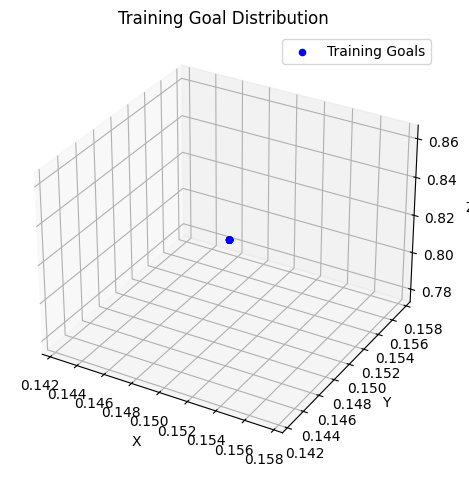

[INFO] Fitting GMM to demonstration data...


2025-04-22,14:48:12.704 INFO GMM fit done.
2025-04-22,14:48:14.237 INFO GMR done.


[INFO] Plotting GMR vs Demonstration data...


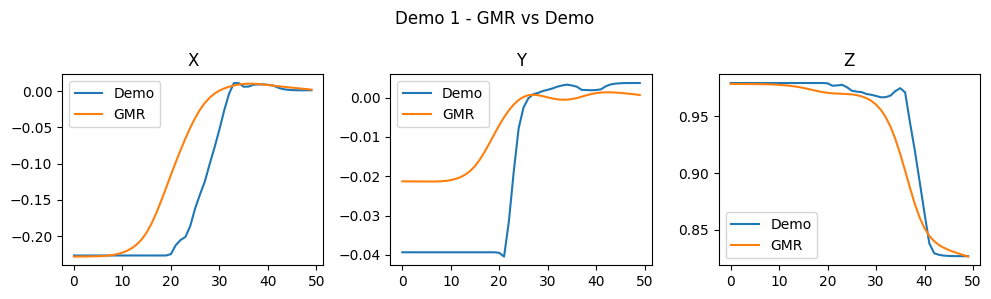

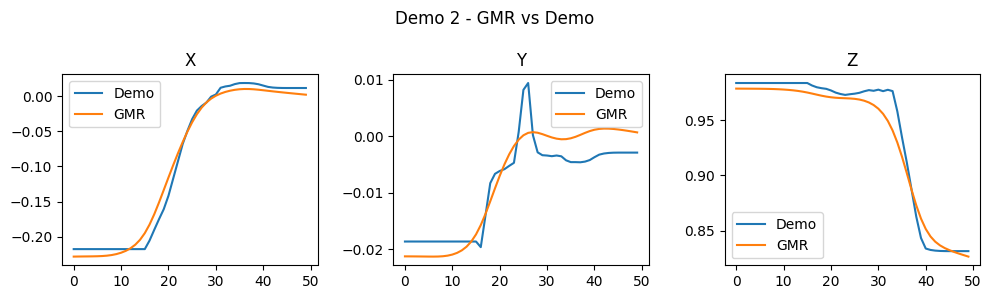

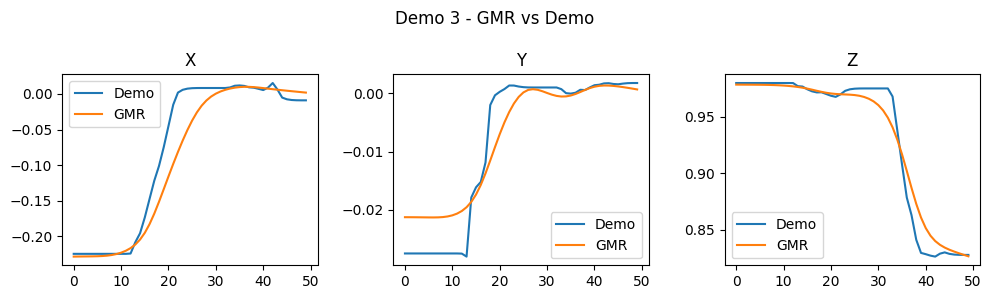

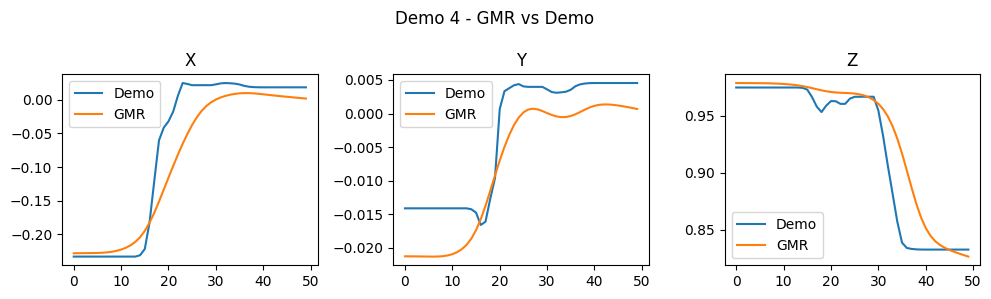

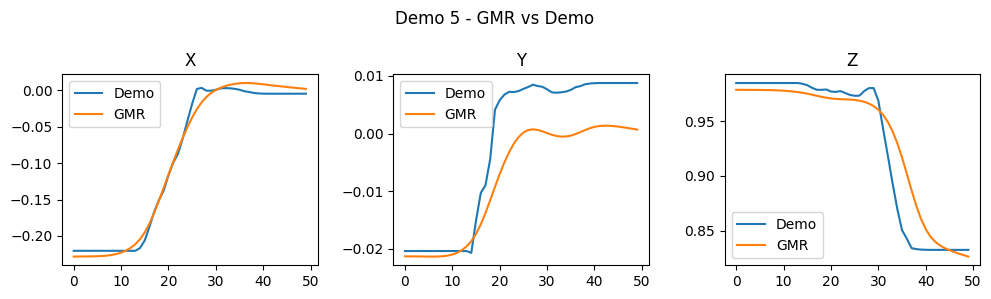

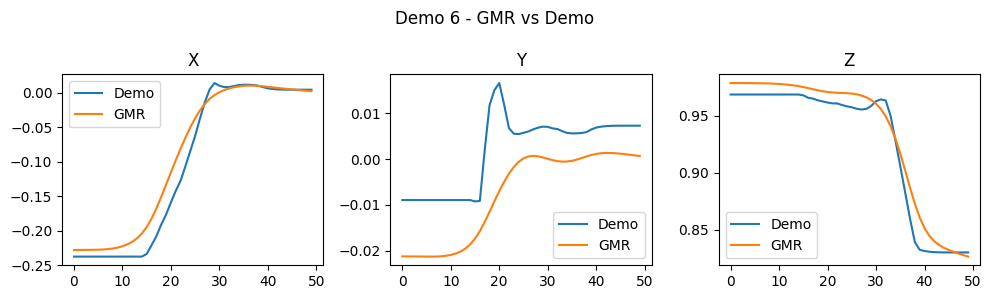

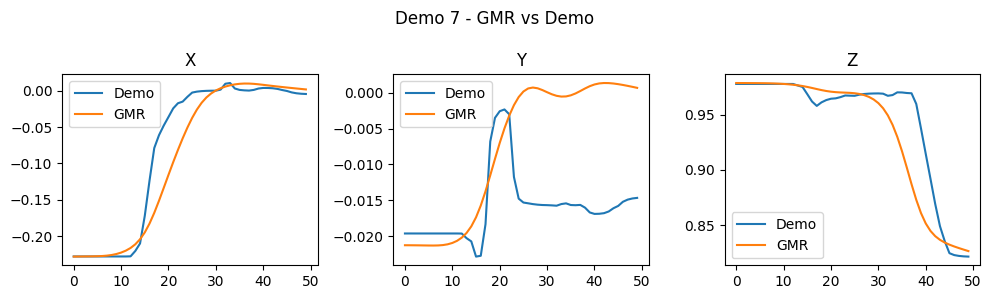

[INFO] Fitting KMP to GMR output with 10 bias points...


2025-04-22,14:48:21.670 INFO KMP fit done. Num waypoints: 360, Output dim: 3
2025-04-22,14:48:31.420 INFO KMP predict done.


[INFO] KMP training complete. MSE: 0.000142
[INFO] Saved model to models/reach_kmp_model.h5


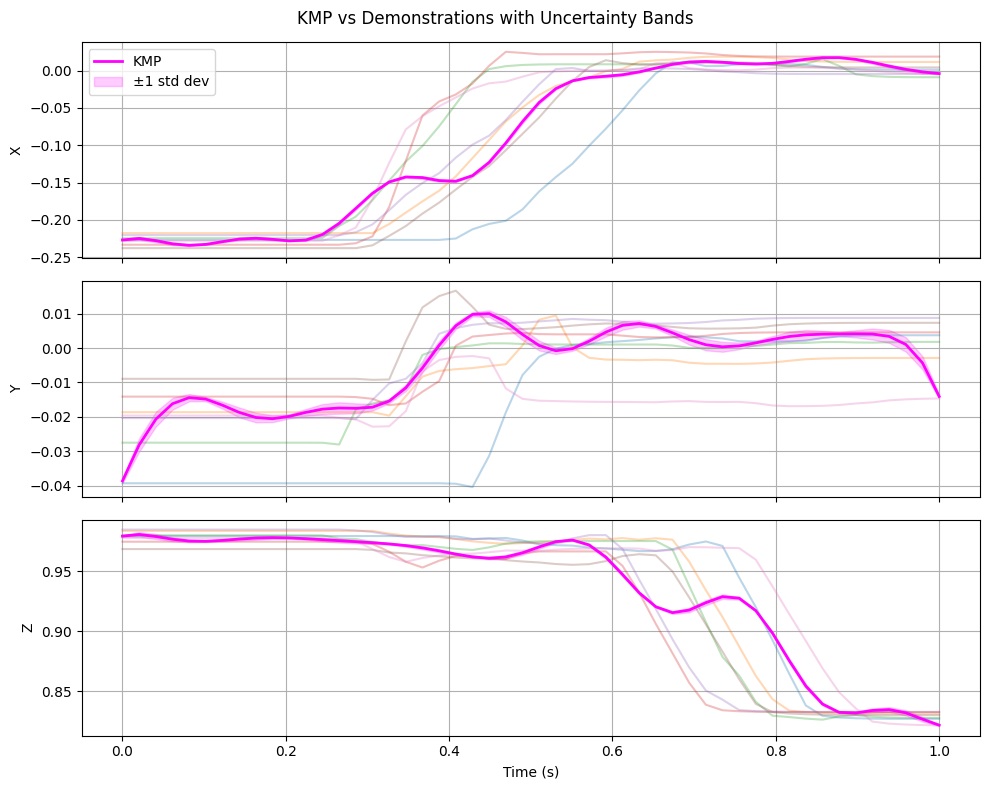


=== Training skill: TRANSPORT ===
[INFO] Loaded 7 demos.


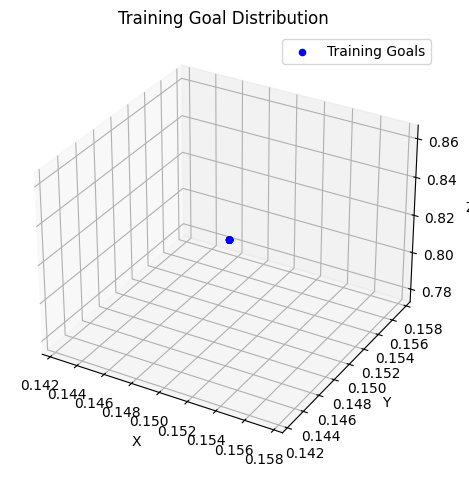

2025-04-22,14:48:32.763 INFO GMM fit done.


[INFO] Fitting GMM to demonstration data...


2025-04-22,14:48:34.136 INFO GMR done.


[INFO] Plotting GMR vs Demonstration data...


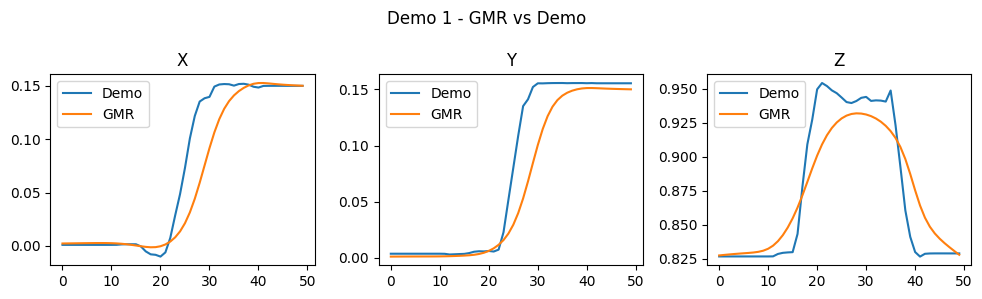

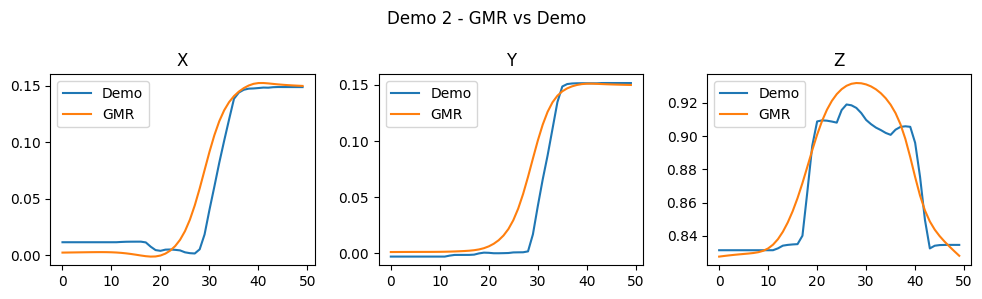

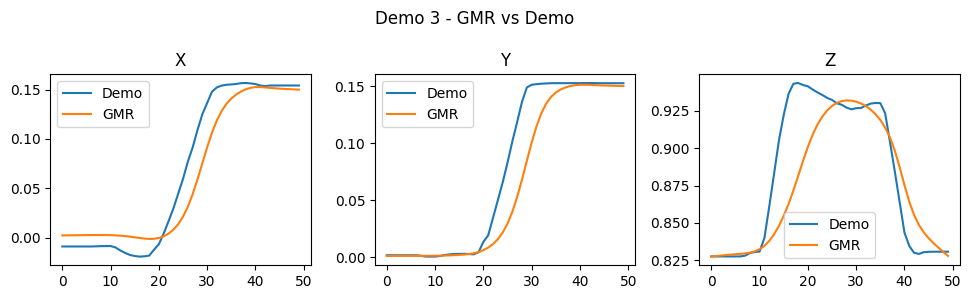

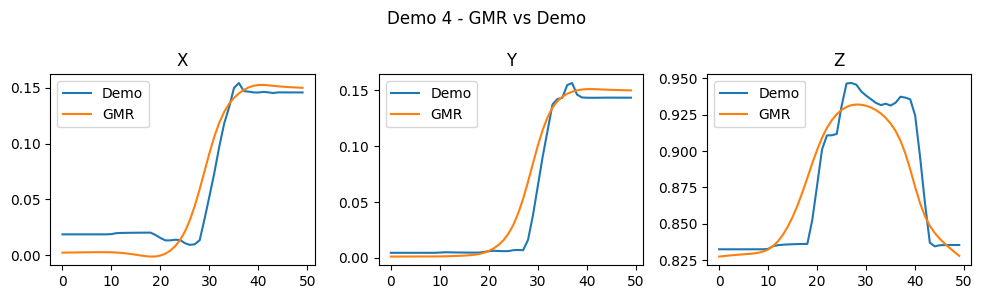

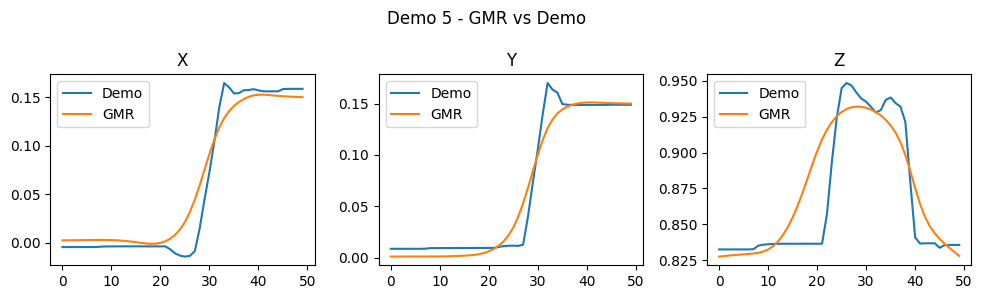

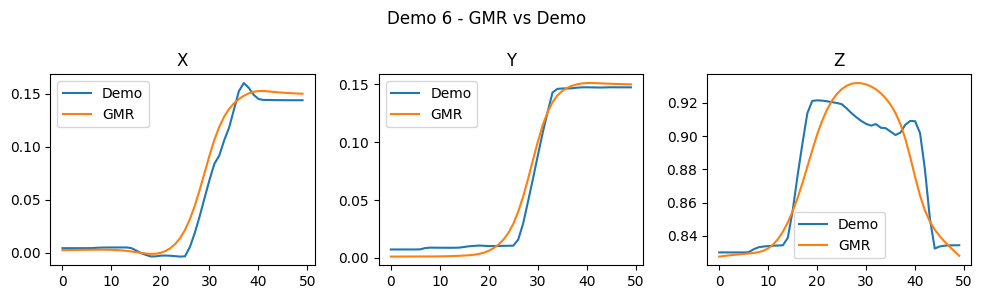

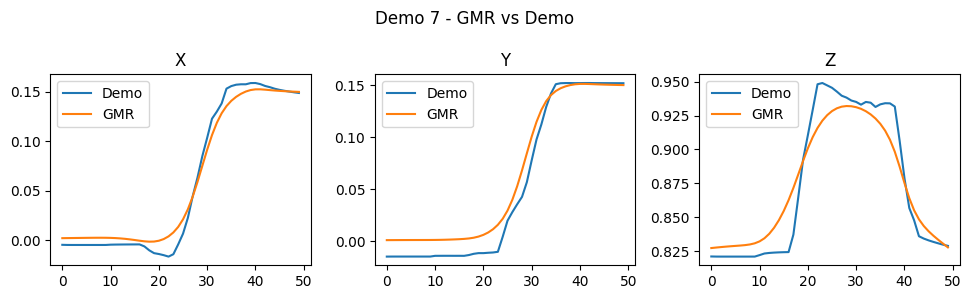

[INFO] Fitting KMP to GMR output with 10 bias points...


2025-04-22,14:48:41.809 INFO KMP fit done. Num waypoints: 360, Output dim: 3
2025-04-22,14:48:49.761 INFO KMP predict done.


[INFO] KMP training complete. MSE: 0.000324
[INFO] Saved model to models/transport_kmp_model.h5


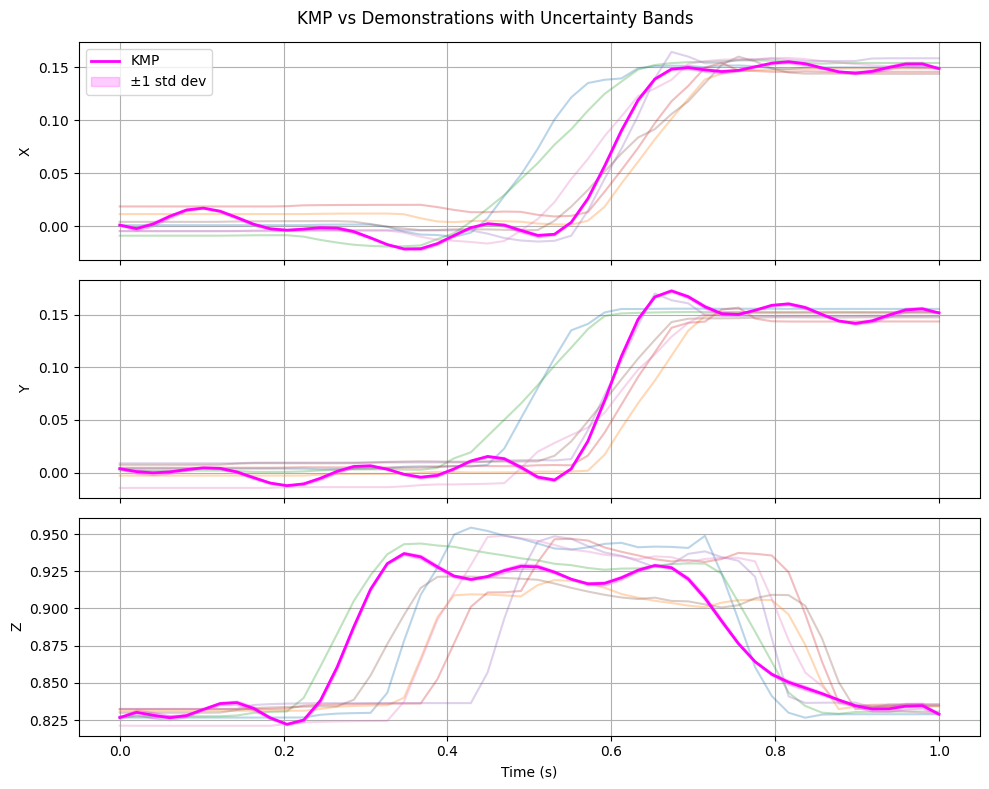


=== Training skill: RETREAT ===
[INFO] Loaded 7 demos.


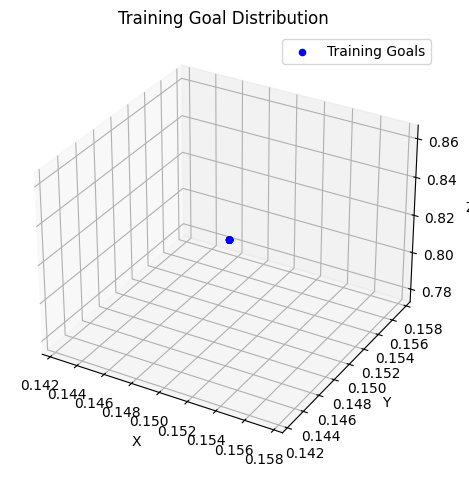

2025-04-22,14:48:51.024 INFO GMM fit done.


[INFO] Fitting GMM to demonstration data...


2025-04-22,14:48:52.403 INFO GMR done.


[INFO] Plotting GMR vs Demonstration data...


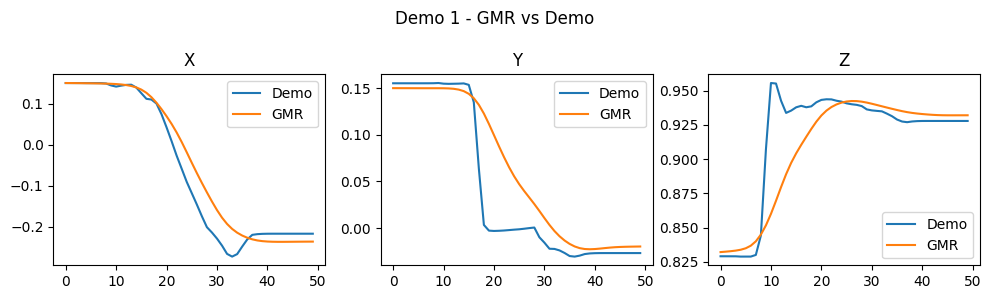

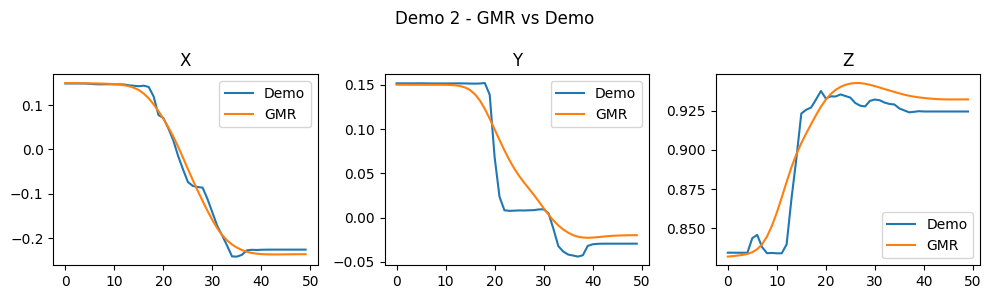

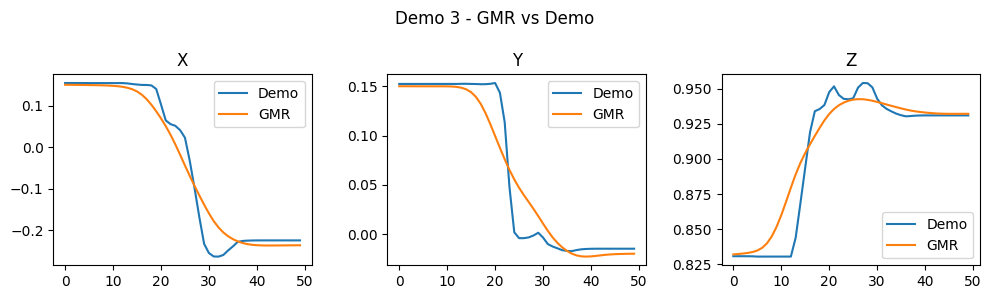

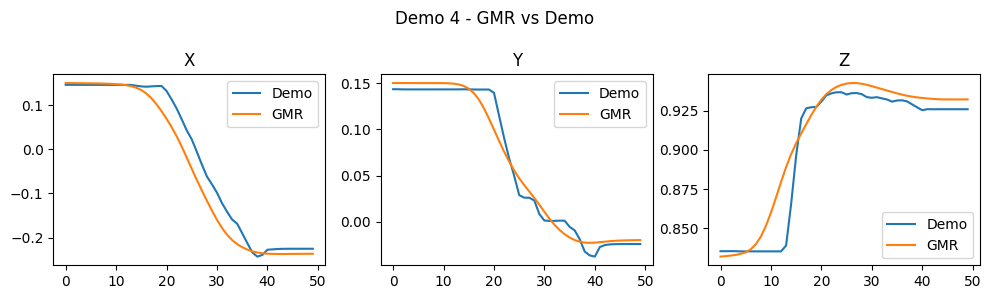

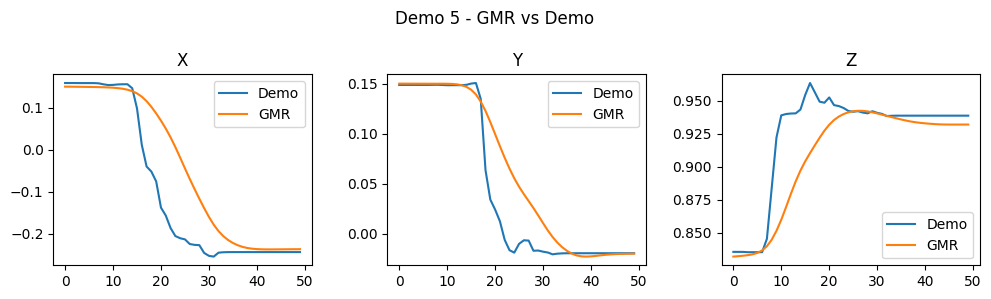

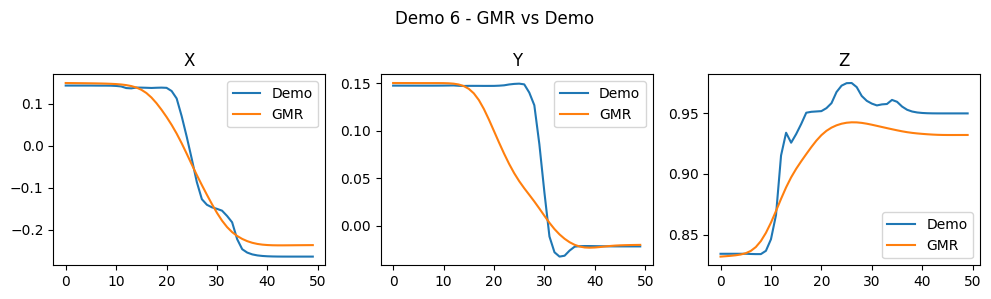

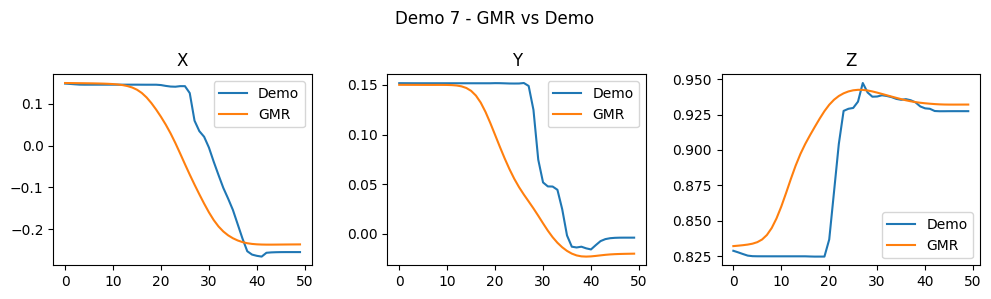

[INFO] Fitting KMP to GMR output with 10 bias points...


2025-04-22,14:48:59.904 INFO KMP fit done. Num waypoints: 360, Output dim: 3
2025-04-22,14:49:05.003 INFO KMP predict done.


[INFO] KMP training complete. MSE: 0.000480
[INFO] Saved model to models/retreat_kmp_model.h5


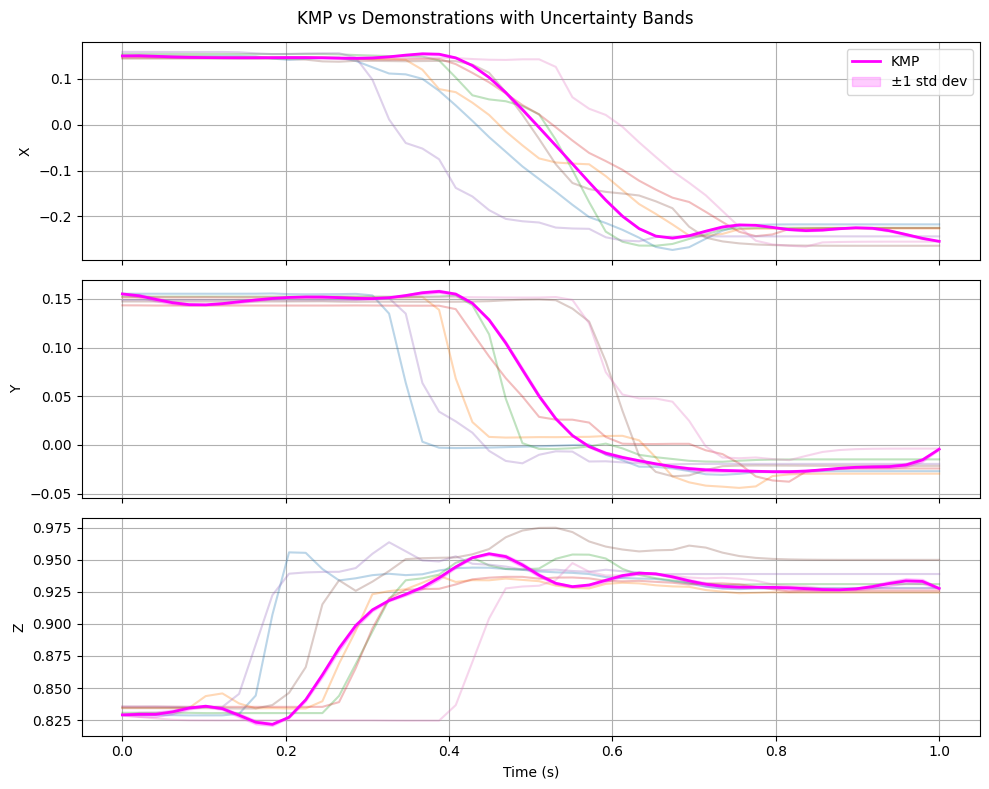

[INFO] Press Enter to close... 


''

In [14]:
CONFIG = {
    "h5_path": "DEMO/smoothed_demo/smoothed_skills.h5",
    "save_model_dir": "models/",
    "kmp_dt": 0.05,
    "skills": ["reach", "transport","retreat"],  
    "kmp_params": dict(
        l=0.4,
        alpha=1e-1,
        sigma_f=34,
        n_components=10,
        diag_reg_factor=1e-3
    )
}

for skill in CONFIG["skills"]:
        print(f"\n=== Training skill: {skill.upper()} ===")
        demos, goals = load_demos(CONFIG["h5_path"], skill)
        if not demos:
            print(f"[WARNING] No demos found for skill '{skill}' — skipping.")
            continue
        visualize_goals(goals)
        time, mu_kmp, sigma_kmp, inputs, kmp, goals = train_kmp(demos, goals)
        save_path = os.path.join(CONFIG["save_model_dir"], f"{skill}_kmp_model.h5")
        save_model(save_path, time, mu_kmp, sigma_kmp, inputs, kmp, goals)
        plot_trajectory(demos, time, mu_kmp, sigma_kmp)
input("[INFO] Press Enter to close...")


In [15]:
# Testing Code: With PLanner

In [16]:
import os
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
import robosuite as suite
from robosuite.wrappers.visualization_wrapper import VisualizationWrapper
from kmp.model import KMP

In [17]:
CONFIG = {
    "model_path_reach": "models/reach_kmp_model.h5",
    "model_path_transfer": "models/transport_kmp_model.h5",
    "control_freq": 50,
    "test_goals": [  # Cube positions
        [0.2, 0.35, 0.82],
    ],
    "place_positions": [[0.15, -0.25, 0.82]]  # Red marker target
}

Z_MIN, Z_MAX = 0.71, 4.0


In [18]:
def load_kmp_model(path):
    with h5py.File(path, "r") as f:
        mu_kmp = np.array(f["mu_kmp"])
        sigma_kmp = np.array(f["sigma_kmp"])
        time_kmp = np.array(f["time"])
        input_kmp = np.array(f["input_kmp"])
        dt = f.attrs["dt"]
        kmp_params = {
            "l": f.attrs["kmp_l"],
            "alpha": f.attrs["kmp_alpha"],
            "sigma_f": f.attrs["kmp_sigma_f"]
        }

    kmp = KMP(
        l=0.01,
        alpha=kmp_params["alpha"],
        sigma_f=0.2,
        time_driven_kernel=False
    )
    kmp.fit(input_kmp, mu_kmp, sigma_kmp)
    return kmp, dt


In [19]:
def run_kmp_trajectory(kmp, start_pos, goal, env, dt, time_kmp, phase_name):
    start_pos = np.array(start_pos)
    goal = np.array(goal)

    start_input = np.hstack(([0.0], start_pos[:3])).reshape(-1, 1)  # Keep the first 3 elements
    goal_input = np.hstack(([1.0], goal[:3])).reshape(-1, 1)  # Keep the first 3 elements

    start_output = start_pos.reshape(-1, 1)
    goal_output = goal.reshape(-1, 1)
    cov = np.eye(3)[..., None] * 1e-6

    # set waypint
    kmp.set_waypoint(
        [start_input, goal_input],
        [start_output, goal_output],
        [cov, cov]
    )

    input_query = []
    for t in time_kmp.flatten():
        interp = (1 - t) * start_pos + t * goal
        input_query.append(np.hstack(([t], interp)))
    input_query = np.array(input_query).T

    mu_pred, sigma_pred = kmp.predict(input_query)
    print(f"[{phase_name}] | Expected final KMP target position: {mu_pred[:3, -1]}")

    actual_traj = []
    obs = env._get_observations()  # initial Observation

    # Loop over time_kmp instead of using `t` from the while loop
    for i, t in enumerate(time_kmp.flatten()):
        target_pos = mu_pred[:3, i]
        current_pos = obs["robot0_eef_pos"]
        delta = target_pos - current_pos
    
        if np.linalg.norm(delta) < 0.0002:
            actual_traj.append(current_pos.copy())
            continue
    
        ACTION_SCALE = 0.005
        action = np.zeros(env.action_spec[0].shape)
        #action[:3] = delta * 1.2
        action[:3] = np.clip(delta / ACTION_SCALE, -5, 5)
        #action[3:] = obs["robot0_eef_quat"]  # Keep the current orientation

        obs, _, _, _ = env.step(action)
        env.render()
        time.sleep(dt)

        actual_traj.append(obs["robot0_eef_pos"].copy())

    print(f"[{phase_name}] | Final robot EE position: {obs['robot0_eef_pos']}")
    error = np.linalg.norm(mu_pred[:3, -1] - obs["robot0_eef_pos"])
    print(f"[{phase_name}] | Final position error: {error:.4f} meters")

    actual_traj = np.array(actual_traj).T
    return obs, actual_traj, mu_pred, sigma_pred


In [20]:
def gripper_control(env,action):
    if action == "open":
        gripper_action = -1.0  # Open
    elif action == "close":
        gripper_action = 1.0   # Close
    else:
        raise ValueError("Invalid action. Choose either 'open' or 'close'.")

    robot = env.robots[0]
    action = np.zeros(env.action_dim)
    action[-1] = gripper_action

    # Apply the gripper command (possibly multiple steps for it to execute)
    for _ in range(5):
        obs, reward, done, info = env.step(action)

    print(f"Gripper {action} command sent.")


In [21]:
def plot_kmp_vs_actual(mu_pred, sigma_pred, actual_traj, start_pos, goal, time_kmp, title):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    labels = ["X", "Y", "Z"]
    
    for j in range(3):
        std_dev = np.sqrt(np.maximum(sigma_pred[j, j, :], 0))
        
        # Plot the KMP Prediction
        axes[j].plot(time_kmp.flatten(), mu_pred[j], label="KMP Prediction", color="magenta")
        
        # Plot ±1 Std Dev
        axes[j].fill_between(
            time_kmp.flatten(),
            mu_pred[j] - std_dev,
            mu_pred[j] + std_dev,
            color="magenta", alpha=0.2,
            label="±1 Std Dev" if j == 0 else None
        )
        
        # Plot the actual trajectory
        axes[j].plot(time_kmp.flatten(), actual_traj[j], label="Actual Trajectory", color="blue", linestyle="--")
        
        # Start and Goal
        axes[j].scatter([0.0], [start_pos[j]], color="green", marker="o", s=50, label="Start" if j == 0 else None)
        axes[j].scatter([1.0], [goal[j]], color="red", marker="x", s=60, label="Goal" if j == 0 else None)
        
        axes[j].set_ylabel(labels[j])
        axes[j].grid(True)
        
        if j == 0:
            axes[j].legend()
    
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [22]:
def run_combined_kmp_execution(reach_model_path, transfer_model_path, test_goals, place_positions):
    kmp_reach, dt_reach = load_kmp_model(reach_model_path)
    kmp_transfer, dt_transfer = load_kmp_model(transfer_model_path)
    T = 100
    time_kmp = np.linspace(0, 1, T).reshape(1, -1)

    env = suite.make(
        env_name="Lift",
        robots="UR5e",
        has_renderer=True,
        use_camera_obs=False,
        control_freq=CONFIG["control_freq"],
        ignore_done=True,
        horizon=100
    )
    env = VisualizationWrapper(env, indicator_configs="default")

    for i, (goal, place) in enumerate(zip(test_goals, place_positions)):
        print(f"\n Test {i + 1} | Reach Goal: {goal} | Place Target: {place}")
        obs = env.reset()

        quat = np.array([1, 0, 0, 0])
        env.sim.data.set_joint_qpos("cube_joint0", np.concatenate([goal, quat]))
        env.sim.forward()

        env.set_indicator_pos("indicator0", place)

        START_POS = obs["robot0_eef_pos"].copy()

        obs, actual_traj_reach, mu_pred_reach, sigma_pred_reach = run_kmp_trajectory(
            kmp_reach, START_POS, goal, env, dt_reach, time_kmp, "Reach"
        )
        plot_kmp_vs_actual(mu_pred_reach, sigma_pred_reach, actual_traj_reach,START_POS, goal, time_kmp, f"Reach Trajectory (Test {i + 1})")
        gripper_control(env, action="close")  # Close the gripper

        TRANSFER_START = obs["robot0_eef_pos"].copy()
        obs, actual_traj_transfer, mu_pred_transfer, sigma_pred_transfer = run_kmp_trajectory(
            kmp_transfer, TRANSFER_START, place, env, dt_transfer, time_kmp, "Transfer"
        )
        gripper_control(env, action="open")  # Close the gripper
        
        plot_kmp_vs_actual(mu_pred_transfer, sigma_pred_transfer, actual_traj_transfer,TRANSFER_START, place, time_kmp, f"Transfer Trajectory (Test {i + 1})")

    env.close()
    print("\n✅ All reach + transfer executions completed.")

if __name__ == "__main__":
    run_combined_kmp_execution(
        CONFIG["model_path_reach"],
        CONFIG["model_path_transfer"],
        CONFIG["test_goals"],
        CONFIG["place_positions"])

2025-04-22,14:49:22.764 INFO KMP fit done. Num waypoints: 350, Output dim: 3
2025-04-22,14:49:25.036 INFO KMP fit done. Num waypoints: 350, Output dim: 3
[robosuite ERROR] Error opening controller filepath at: /mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json. Please check filepath and try again. (composite_controller_factory.py:123)
2025-04-22,14:49:25.041 ERROR Error opening controller filepath at: /mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json. Please check filepath and try again.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json'

In [16]:
# With Planner

In [17]:
import time
import numpy as np
import robosuite as suite
from robosuite import load_composite_controller_config
from robosuite.environments.manipulation.lift import Lift
from robosuite.wrappers.visualization_wrapper import VisualizationWrapper
from robosuite.environments import REGISTERED_ENVS

REGISTERED_ENVS["MyCustomLift"] = Lift


In [18]:
CONFIG = {
    "model_path_reach": "models/reach_kmp_model.h5",
    "model_path_transfer": "models/transport_kmp_model.h5",
    "control_freq": 50,
    "test_goals": [  # Cube positions
        [0.2, 0.35, 0.82],
    ],
    "place_positions": [[0.15, -0.25, 0.82]]  # Red marker target
}

Z_MIN, Z_MAX = 0.71, 4.0


In [19]:
def run_combined_kmp_execution(reach_model_path, transfer_model_path, test_goals, place_positions):
    kmp_reach, dt_reach = load_kmp_model(reach_model_path)
    kmp_transfer, dt_transfer = load_kmp_model(transfer_model_path)
    T = 100
    time_kmp = np.linspace(0, 1, T).reshape(1, -1)

    # Create the environment for the task
    env = suite.make(
        env_name="MyCustomLift",
        robots="UR5e",
        has_renderer=True,
        use_camera_obs=False,
        control_freq=CONFIG["control_freq"],
        ignore_done=True,
        horizon=100
    )
    env = VisualizationWrapper(env, indicator_configs="default")

    # Get the model to dynamically add cubes
    model = env.sim.model

    # Add cube geometries and bodies using the proper Robosuite API
    for i in range(3):  # Assuming 3 cubes to be added
        # Add cube body
        body_name = f"cube{i}"
        joint_name = f"cube_joint{i}"
        
        model.body_add(name=body_name, pos=[0, 0, 0.1 + i * 0.1])
        model.joint_add(name=joint_name, type='free', body_name=body_name)
        
        # You might also need to define the visual geometry of the cubes
        model.geom_add(name=f"cube_geom{i}", type='box', size=[0.05, 0.05, 0.05], rgba=[1, 0, 0, 1], body_name=body_name)

    for i, (goal, place) in enumerate(zip(test_goals, place_positions)):
        print(f"\nTest {i + 1} | Reach Goal: {goal} | Place Target: {place}")
        obs = env.reset()

        # Set position for all three cubes (example positions)
        quat = np.array([1, 0, 0, 0])  # No rotation

        # Set joint positions for cubes A, B, and C
        env.sim.data.set_joint_qpos("cube_joint0", np.concatenate([np.array(goal), quat]))  # Cube A
        env.sim.data.set_joint_qpos("cube_joint1", np.concatenate([np.array(goal) + np.array([0.1, 0, 0]), quat]))  # Cube B
        env.sim.data.set_joint_qpos("cube_joint2", np.concatenate([np.array(goal) + np.array([0, 0.1, 0]), quat]))  # Cube C
        env.sim.forward()

        # Set visual indicator for placement positions
        env.set_indicator_pos("indicator0", place)

        # Reach trajectory
        START_POS = obs["robot0_eef_pos"].copy()
        obs, actual_traj_reach, mu_pred_reach, sigma_pred_reach = run_kmp_trajectory(
            kmp_reach, START_POS, goal, env, dt_reach, time_kmp, f"Reach (Test {i + 1})"
        )
        plot_kmp_vs_actual(mu_pred_reach, sigma_pred_reach, actual_traj_reach, START_POS, goal, time_kmp,
                           f"Reach Trajectory (Test {i + 1})")

        gripper_control(env, action="close")

        # Transfer trajectory
        TRANSFER_START = obs["robot0_eef_pos"].copy()
        obs, actual_traj_transfer, mu_pred_transfer, sigma_pred_transfer = run_kmp_trajectory(
            kmp_transfer, TRANSFER_START, place, env, dt_transfer, time_kmp, f"Transfer (Test {i + 1})"
        )
        gripper_control(env, action="open")
        plot_kmp_vs_actual(mu_pred_transfer, sigma_pred_transfer, actual_traj_transfer, TRANSFER_START, place,
                           time_kmp, f"Transfer Trajectory (Test {i + 1})")

    env.close()
    print("\nAll reach + transfer executions completed.")




if __name__ == "__main__":
    run_combined_kmp_execution(
        CONFIG["model_path_reach"],
        CONFIG["model_path_transfer"],
        CONFIG["test_goals"],         # Shape: (N_tests, 3)
        CONFIG["place_positions"]     # Shape: (N_tests, 3)
    )


2025-04-22,03:26:36.524 INFO KMP fit done. Num waypoints: 350, Output dim: 3
2025-04-22,03:26:37.827 INFO KMP fit done. Num waypoints: 350, Output dim: 3
[robosuite INFO] Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_ur5e.json (composite_controller_factory.py:121)
2025-04-22,03:26:37.830 INFO Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_ur5e.json
[robosuite INFO] Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_ur5e.json (composite_controller_factory.py:121)
2025-04-22,03:26:39.291 INFO Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_ur5e.json


AttributeError: 'MjModel' object has no attribute 'body_add'

In [26]:
import time
import numpy as np
import robosuite as suite
from robosuite import load_composite_controller_config
from robosuite.environments.manipulation.lift import Lift
from robosuite.controllers.parts.arm.osc import OperationalSpaceController
from robosuite.environments import REGISTERED_ENVS

# Register your custom Lift environment
REGISTERED_ENVS["MyCustomLift"] = Lift

# Load controller configuration (using the "BASIC" controller)
controller_config = load_composite_controller_config(controller="BASIC")

# Create the environment instance
env = suite.make(
    env_name="MyCustomLift",         # Environment name (MyCustomLift, a custom Lift)
    robots="Jaco",                   # Robot type (Jaco)
    controller_configs=controller_config,  # Controller configuration
    has_renderer=True,               # Enable rendering
    renderer="mujoco",               # Renderer type (Mujoco)
    use_camera_obs=False,            # Disable camera observations
    control_freq=20,                 # Control frequency (Hz)
)

# Reset the environment to initialize everything
env.reset()

# Get the action space through the robot's controller
robot = env.robots[0]  # Assuming there's only one robot
action_space = robot.controller.action_space  # Get the action space from the robot's controller

# Now you can interact with the environment, for example, running a simple loop
# to simulate and observe the robot

for _ in range(1000):
    action = action_space.sample()  # Sample a random action from the action space
    obs, reward, done, info = env.step(action)  # Take a step in the environment
    
    # Optionally, render the environment every 50 steps
    if _ % 50 == 0:
        env.render()

    # Stop if done
    if done:
        break

# Close the environment when done
env.close()


[robosuite INFO] Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json (composite_controller_factory.py:121)
2025-04-22,03:32:20.392 INFO Loading controller configuration from: /home/spatel/.local/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json
[robosuite WARNING] The config has defined for the controller "left", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for left from self.part_controller_config. (robot.py:151)
2025-04-22,03:32:21.618 WARNING The config has defined for the controller "left", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for left from self.part_controller_config.
[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure 

AttributeError: 'FixedBaseRobot' object has no attribute 'controller'

ImportError: cannot import name 'Keyboard' from 'robosuite.controllers' (/mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/__init__.py)

In [ ]:
def run_combined_kmp_execution(reach_model_path, transfer_model_path, test_goals, place_positions, config):
    """
    Execute combined KMP reach and transfer trajectories for robotic manipulation with 3 cubes.
    """
    # Load KMP models
    kmp_reach, dt_reach = load_kmp_model(reach_model_path)
    kmp_transfer, dt_transfer = load_kmp_model(transfer_model_path)
    T = 100
    time_kmp = np.linspace(0, 1, T).reshape(1, -1)

    # Create environment
    env = suite.make(
        env_name="MyCustomLift",
        robots="UR5e",
        #controller_configs=load_controller_config(default_controller="OSC_POSE"),
        has_renderer=True,
        use_camera_obs=False,
        control_freq=config["control_freq"],
        ignore_done=True,
        horizon=100,
        hard_reset=True
    )
    env = VisualizationWrapper(env, indicator_configs="default")

    for i, (goal_info, place) in enumerate(zip(test_goals, place_positions)):
        cube_name = goal_info['cube_name']
        goal_pos = goal_info['position']
        
        print(f"\nTest {i + 1} | Target Cube: {cube_name} | Reach Goal: {goal_pos} | Place Target: {place}")
        
        # Reset environment
        obs = env.reset()
        
        # Set initial cube positions
        quat = np.array([1, 0, 0, 0])  # Identity quaternion
        
        # Access cubes through model's mujoco_objects
        for obj in env.model.mujoco_objects:
            if obj.name == cube_name:
                # Set target cube to goal position
                env.sim.data.set_joint_qpos(f"{obj.joints[0]}", np.concatenate([goal_pos, quat]))
            else:
                # Set other cubes to random positions
                random_pos = np.random.uniform(-0.1, 0.1, size=3)
                env.sim.data.set_joint_qpos(f"{obj.joints[0]}", np.concatenate([random_pos, quat]))
        
        env.sim.forward()
        env.set_indicator_pos("indicator0", place)

        # --- Reach Phase ---
        START_POS = obs["robot0_eef_pos"].copy()
        obs, actual_traj_reach, mu_pred_reach, sigma_pred_reach = run_kmp_trajectory(
            kmp_reach, START_POS, goal_pos, env, dt_reach, time_kmp, "Reach"
        )
        
        # Visualize and plot
        if env.has_renderer:
            env.render()
        plot_kmp_vs_actual(mu_pred_reach, sigma_pred_reach, actual_traj_reach,
                          START_POS, goal_pos, time_kmp, 
                          f"Reach {cube_name} (Test {i + 1})")
        
        # Close gripper on target cube
        gripper_control(env, action="close")
        time.sleep(0.5) if env.has_renderer else None

        # --- Transfer Phase ---
        TRANSFER_START = obs["robot0_eef_pos"].copy()
        obs, actual_traj_transfer, mu_pred_transfer, sigma_pred_transfer = run_kmp_trajectory(
            kmp_transfer, TRANSFER_START, place, env, dt_transfer, time_kmp, "Transfer"
        )
        
        # Visualize and plot
        if env.has_renderer:
            env.render()
        plot_kmp_vs_actual(mu_pred_transfer, sigma_pred_transfer, actual_traj_transfer,
                          TRANSFER_START, place, time_kmp,
                          f"Transfer {cube_name} (Test {i + 1})")
        
        # Open gripper
        gripper_control(env, action="open")
        time.sleep(0.5) if env.has_renderer else None

    env.close()
    print("\n✅ All reach + transfer executions completed.")

if __name__ == "__main__":
    # Example configuration
    CONFIG = {
        "model_path_reach": "models/reach_kmp_model.h5",
        "model_path_transfer": "models/transport_kmp_model.h5",
        "test_goals": [
            {"cube_name": "cube_red_main", "position": [0.1, 0.1, 0.82]},
            {"cube_name": "cube_green_main", "position": [0.1, -0.1, 0.82]},
            {"cube_name": "cube_blue_main", "position": [-0.1, 0.1, 0.82]}
        ],
        "place_positions": [
            [0.1, 0.1, 0.82],
            [-0.1, -0.1, 0.82],
            [0.1, -0.1, 0.82]
        ],
        "control_freq": 20
    }

    run_combined_kmp_execution(
        reach_model_path=CONFIG["model_path_reach"],
        transfer_model_path=CONFIG["model_path_transfer"],
        test_goals=CONFIG["test_goals"],
        place_positions=CONFIG["place_positions"],
        config=CONFIG
    )

In [14]:
!pip uninstall robosuite


Found existing installation: robosuite 1.5.1
Uninstalling robosuite-1.5.1:
  Would remove:
    /mnt/e/sem3/Robot Learning/Final_Project/venv/lib/python3.10/site-packages/__editable__.robosuite-1.5.1.pth
    /mnt/e/sem3/Robot Learning/Final_Project/venv/lib/python3.10/site-packages/__editable___robosuite_1_5_1_finder.py
    /mnt/e/sem3/Robot Learning/Final_Project/venv/lib/python3.10/site-packages/robosuite-1.5.1.dist-info/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [23]:
from collections import OrderedDict
import numpy as np
import robosuite

from robosuite.utils.transform_utils import convert_quat
from robosuite.utils.mjcf_utils import CustomMaterial

from robosuite.environments.manipulation.lift import Lift

from robosuite.models.arenas import TableArena
from robosuite.models.objects import BoxObject
from robosuite.models.tasks import ManipulationTask
from robosuite.utils.placement_samplers import UniformRandomSampler
from robosuite.utils.observables import Observable, sensor


class NewLift(Lift):
   
    def __init__(
        self,
        robots,
        env_configuration="default",
        controller_configs=None,
        gripper_types="default",
        initialization_noise="default",
        table_full_size=(0.8, 0.8, 0.05),
        table_friction=(1.0, 5e-3, 1e-4),
        use_camera_obs=True,
        use_object_obs=True,
        reward_scale=1.0,
        reward_shaping=False,
        placement_initializer=None,
        has_renderer=False,
        has_offscreen_renderer=True,
        render_camera="frontview",
        render_collision_mesh=False,
        render_visual_mesh=True,
        render_gpu_device_id=-1,
        control_freq=20,
        lite_physics=True,
        horizon=1000,
        ignore_done=False,
        hard_reset=True,
        camera_names="agentview",
        camera_heights=256,
        camera_widths=256,
        camera_depths=False,
        camera_segmentations=None,  # {None, instance, class, element}
        renderer="mjviewer",
        renderer_config=None,
    ):
        # settings for table top
        self.table_full_size = table_full_size
        self.table_friction = table_friction
        self.table_offset = np.array((0, 0, 0.8))

        # reward configuration
        self.reward_scale = reward_scale
        self.reward_shaping = reward_shaping

        # whether to use ground-truth object states
        self.use_object_obs = use_object_obs

        # object placement initializer
        self.placement_initializer = placement_initializer

        super().__init__(
            robots=robots,
            env_configuration=env_configuration,
            controller_configs=controller_configs,
            gripper_types=gripper_types,
            initialization_noise=initialization_noise,
            use_camera_obs=use_camera_obs,
            has_renderer=has_renderer,
            has_offscreen_renderer=has_offscreen_renderer,
            render_camera=render_camera,
            render_collision_mesh=render_collision_mesh,
            render_visual_mesh=render_visual_mesh,
            render_gpu_device_id=render_gpu_device_id,
            control_freq=control_freq,
            lite_physics=lite_physics,
            horizon=horizon,
            ignore_done=ignore_done,
            hard_reset=hard_reset,
            camera_names=camera_names,
            camera_heights=camera_heights,
            camera_widths=camera_widths,
            camera_depths=camera_depths,
            camera_segmentations=camera_segmentations,
            renderer=renderer,
            renderer_config=renderer_config,

        )

    def reward(self, action=None):
        reward = 0.

        # sparse completion reward
        if self._check_success():
            reward = 2.25

        # use a shaping reward
        elif self.reward_shaping:

            # reaching reward
            cube_pos = self.sim.data.body_xpos[self.cubeA_body_id]
            gripper_site_pos = self.sim.data.site_xpos[self.robots[0].eef_site_id]
            dist = np.linalg.norm(gripper_site_pos - cube_pos)
            reaching_reward = 1 - np.tanh(10.0 * dist)
            reward += reaching_reward

            # grasping reward
            if self._check_grasp(gripper=self.robots[0].gripper, object_geoms=self.cubeA):
                reward += 0.25

        # Scale reward if requested
        if self.reward_scale is not None:
            reward *= self.reward_scale / 2.25

        return reward

    def _load_model(self):
        """
        Loads an xml model, puts it in self.model
        """
        super()._load_model()

        # Adjust base pose accordingly
        xpos = self.robots[0].robot_model.base_xpos_offset["table"](self.table_full_size[0])
        self.robots[0].robot_model.set_base_xpos(xpos)

        # load model for table top workspace
        mujoco_arena = TableArena(
            table_full_size=self.table_full_size,
            table_friction=self.table_friction,
            table_offset=self.table_offset,
        )

        # Arena always gets set to zero origin
        mujoco_arena.set_origin([0, 0, 0])

        # Initialize materials
        tex_attrib = {"type": "cube"}
        mat_attrib = {"texrepeat": "1 1", "specular": "0.4", "shininess": "0.1"}
        redwood = CustomMaterial(texture="WoodRed", tex_name="redwood",
                                mat_name="redwood_mat", tex_attrib=tex_attrib, mat_attrib=mat_attrib)
        greenwood = CustomMaterial(texture="WoodGreen", tex_name="greenwood",
                                mat_name="greenwood_mat", tex_attrib=tex_attrib, mat_attrib=mat_attrib)
        bluewood = CustomMaterial(texture="WoodBlue", tex_name="bluewood",
                                mat_name="bluewood_mat", tex_attrib=tex_attrib, mat_attrib=mat_attrib)

        # Create cubes with different materials
        self.cubeA = BoxObject(name="cubeA", size_min=[0.02, 0.02, 0.02], size_max=[
                            0.02, 0.02, 0.02], rgba=[1, 0, 0, 1], material=redwood)
        self.cubeB = BoxObject(name="cubeB", size_min=[0.025, 0.025, 0.025], size_max=[
                            0.025, 0.025, 0.025], rgba=[0, 1, 0, 1], material=greenwood)
        self.cubeC = BoxObject(name="cubeC", size_min=[0.03, 0.03, 0.03], size_max=[
                            0.03, 0.03, 0.03], rgba=[0, 0, 1, 1], material=bluewood)

      
        # Add cubes to the environment
        cubes = [self.cubeA, self.cubeB, self.cubeC]

        # Create placement initializer
        if self.placement_initializer is not None:
            self.placement_initializer.reset()
            self.placement_initializer.add_objects(cubes)
        else:
            self.placement_initializer = UniformRandomSampler(
                name="ObjectSampler",
                mujoco_objects=cubes,
                x_range=[-0.08, 0.08],
                y_range=[-0.08, 0.08],
                rotation=None,
                ensure_object_boundary_in_range=False,
                ensure_valid_placement=True,
                reference_pos=self.table_offset,
                z_offset=0.01,
            )

        # task includes arena, robot, and objects of interest
        self.model = ManipulationTask(
            mujoco_arena=mujoco_arena,
            mujoco_robots=[robot.robot_model for robot in self.robots],
            mujoco_objects=cubes,
        )

    def _setup_references(self):
        """
        Sets up references to important components. A reference is typically an
        index or a list of indices that point to the corresponding elements
        in a flatten array, which is how MuJoCo stores physical simulation data.
        """
        super()._setup_references()
    
        # Now add custom cube references (e.g., red, green, blue)
        self.cube_body_ids = {
            "red": self.sim.model.body_name2id("red_cube"),
            "green": self.sim.model.body_name2id("green_cube"),
            "blue": self.sim.model.body_name2id("blue_cube"),
        }
    
        self.cube_site_ids = {
            "red": self.sim.model.site_name2id("red_cube_site"),
            "green": self.sim.model.site_name2id("green_cube_site"),
            "blue": self.sim.model.site_name2id("blue_cube_site"),
        }

    def _setup_observables(self):
        """
        Sets up observables to be used for this environment. Creates object-based observables if enabled

        Returns:
            OrderedDict: Dictionary mapping observable names to its corresponding Observable object
        """
        observables = super()._setup_observables()

        # low-level object information
        if self.use_object_obs:
            # define observables modality
            modality = "object"

            # position and rotation of the first two cubes (cubeA, cubeB)
            @sensor(modality=modality)
            def cubeA_pos(obs_cache):
                return np.array(self.sim.data.body_xpos[self.cubeA_body_id])

            @sensor(modality=modality)
            def cubeA_quat(obs_cache):
                return convert_quat(np.array(self.sim.data.body_xquat[self.cubeA_body_id]), to="xyzw")

            @sensor(modality=modality)
            def cubeB_pos(obs_cache):
                return np.array(self.sim.data.body_xpos[self.cubeB_body_id])

            @sensor(modality=modality)
            def cubeB_quat(obs_cache):
                return convert_quat(np.array(self.sim.data.body_xquat[self.cubeB_body_id]), to="xyzw")

            # position and rotation of the third cube (cubeC)
            @sensor(modality=modality)
            def cubeC_pos(obs_cache):
                return np.array(self.sim.data.body_xpos[self.cubeC_body_id])

            @sensor(modality=modality)
            def cubeC_quat(obs_cache):
                return convert_quat(np.array(self.sim.data.body_xquat[self.cubeC_body_id]), to="xyzw")

            # distances between cubes
            @sensor(modality=modality)
            def cubeA_to_cubeB(obs_cache):
                return (
                    obs_cache["cubeB_pos"] - obs_cache["cubeA_pos"]
                    if "cubeA_pos" in obs_cache and "cubeB_pos" in obs_cache
                    else np.zeros(3)
                )

            @sensor(modality=modality)
            def cubeA_to_cubeC(obs_cache):
                return (
                    obs_cache["cubeC_pos"] - obs_cache["cubeA_pos"]
                    if "cubeA_pos" in obs_cache and "cubeC_pos" in obs_cache
                    else np.zeros(3)
                )

            @sensor(modality=modality)
            def cubeB_to_cubeC(obs_cache):
                return (
                    obs_cache["cubeC_pos"] - obs_cache["cubeB_pos"]
                    if "cubeB_pos" in obs_cache and "cubeC_pos" in obs_cache
                    else np.zeros(3)
                )

            arm_prefixes = self._get_arm_prefixes(
                self.robots[0], include_robot_name=False)
            full_prefixes = self._get_arm_prefixes(self.robots[0])

            # add new sensors for cubeC and the distances between cubes
            sensors = [
                cubeA_pos, cubeA_quat,
                cubeB_pos, cubeB_quat,
                cubeC_pos, cubeC_quat,
                cubeA_to_cubeB, cubeA_to_cubeC, cubeB_to_cubeC
            ]
            sensors += [
                self._get_obj_eef_sensor(
                    full_pf, f"{cube}_pos", f"{arm_pf}gripper_to_{cube}", modality)
                for arm_pf, full_pf in zip(arm_prefixes, full_prefixes)
                for cube in ["cubeA", "cubeB", "cubeC"]
            ]
            names = [s.__name__ for s in sensors]

            # Create observables for the new sensors
            for name, s in zip(names, sensors):
                observables[name] = Observable(
                    name=name,
                    sensor=s,
                    sampling_rate=self.control_freq,
                )

        return observables



    def visualize(self, vis_settings):
        """
        In addition to super call, visualize gripper site proportional to the distance to the cube.

        Args:
            vis_settings (dict): Visualization keywords mapped to T/F, determining whether that specific
                component should be visualized. Should have "grippers" keyword as well as any other relevant
                options specified.
        """
        # Run superclass method first
        super().visualize(vis_settings=vis_settings)

        # Color the gripper visualization site according to its distance to the cube
        if vis_settings["grippers"]:
            for cube in self.cubes:
                self._visualize_gripper_to_target(
                    gripper=self.robots[0].gripper,
                    target=cube
                )

    def _check_success(self):
        """
        Check if cube has been lifted.

        Returns:
            bool: True if cube has been lifted
        """
        cube_height = self.sim.data.body_xpos[self.cubeA_body_id][2]
        table_height = self.model.mujoco_arena.table_offset[2]

        # cube is higher than the table top above a margin
        return cube_height > table_height + 0.04

In [24]:
import numpy as np

class NaiveModel(object):
    def __init__(self, dof):
        self.dof = dof

    def __call__(self, obs=None):
        return np.random.randn(self.dof)

In [25]:
import numpy as np

# initialize environment
robots = "Panda"
env = robosuite.make(
    'NewLift',
    robots,
    has_renderer=True,
    has_offscreen_renderer=False,
    use_camera_obs=False,
    control_freq=20,
)

# initailiza model (random model here)
model = NaiveModel(env.robots[0].dof)

# reset the environment
env.reset()
obs = None

for i in range(1000):
    action = model(obs) # sample random action
    obs, reward, done, info = env.step(action)  # take action in the environment
    env.render()  # render on display

[robosuite ERROR] Error opening controller filepath at: /mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json. Please check filepath and try again. (composite_controller_factory.py:123)
2025-04-22,14:49:43.707 ERROR Error opening controller filepath at: /mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json. Please check filepath and try again.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/sem3/Robot Learning/Project/venv/lib/python3.10/site-packages/robosuite/controllers/config/default/composite/basic.json'